## TUTORIAL 03 - Geometrical parametrization
**_Keywords: geometrical parametrization_**

### 1. Introduction

This Tutorial introduces problems featuring a geometrical parametrization, by solving a thermal conduction problem on a parametrized computational domain $\Omega_o(\boldsymbol{\mu})$.

![mesh](data/mesh.png)

The problem is characterized by three parameters. The parameters $\mu_0$ and $\mu_1$ are related to the shape of the central hole and vary in the following intervals
$$
\mu_0\in[0.5,1.5] \quad \text{and}\quad \mu_1\in[0.5,1.5].
$$

The parameter $\mu_2$ is the Biot number, which allows to parametrize heat exchange with a surrounding exterior fluid (e.g., air) in the following interval
$$
\mu_2\in[0.01,1];
$$
the diffusion process on the external boundaries $\Gamma_{o, 5} \cup \Gamma_{o, 6} \cup \Gamma_{o, 7} \cup \Gamma_{o, 8}$ will be affected by this parameter.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \mu_1, \mu_2)
$$
on the parameter domain
$$
\mathbb{P}=[0.5,1.5]^2\times[0.01,1].
$$

In order to obtain a faster approximation of the problem, and avoiding _any_ remeshing, we pursue a model reduction by means of a POD-Galerkin reduced order method from a fixed reference domain.

### 2. Parametrized formulation

Let $u_o(\boldsymbol{\mu})$ be the temperature in the domain $\Omega_o(\boldsymbol{\mu})$.

We will directly provide a weak formulation for this problem for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u_o(\boldsymbol{\mu})\in\mathbb{V}_o(\boldsymbol{\mu})$ such that

$$a_o\left(u_o(\boldsymbol{\mu}),v_o;\boldsymbol{\mu}\right)=f_o(v_o;\boldsymbol{\mu})\quad \forall v_o\in\mathbb{V}_o(\boldsymbol{\mu})$$

where

* the function space $\mathbb{V}_o(\boldsymbol{\mu})$ is defined as
$$
\mathbb{V}_o(\boldsymbol{\mu}) = H^1(\Omega(\boldsymbol{\mu})).
$$
Note that, in contrast to the previous tutorials, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \times \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$a_o(u_o,v_o;\boldsymbol{\mu}) = \int_{\Omega_o(\boldsymbol{\mu})}\nabla u_o\cdot\nabla v_o \ d\boldsymbol{x} + \mu_2\left(\int_{\Gamma_{o,5}}u_o\,v_o \ ds + \int_{\Gamma_{o,6}}u_o\,v_o \ ds + \int_{\Gamma_{o,7}}u_o\,v_o \ ds + \int_{\Gamma_{o,8}}u_o\,v_o \ ds\right),$$
* the parametrized linear form $f_o(\cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$f_o(v_o;\boldsymbol{\mu}) = \int_{\Gamma_{o,1}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,2}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,3}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,4}(\boldsymbol{\mu})}v_o \ ds.$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

In order to obtain an affine decomposition, we need to recast the problem on a fixed, parameter _independent_, reference domain, as follows:

1. Choose $\Omega = \Omega_o((\mu_0, \mu_1) \equiv (1, 1))$ as reference domain, which we generate through the generate_mesh notebook provided in the _data_ folder.
2. Define a map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu}): \Omega \to \Omega_o(\boldsymbol{\mu})$ to carry out a pull back of the problem from the parametrized domain $\Omega_o(\boldsymbol{\mu})$ to the reference one $\Omega$. Since we aim at obtaining an affine decomposition, the map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu})$ should be affine in its first argument. This is possible by taking a partition of the reference domain in several triangular subdomains.
3. Define a reference function space $$\mathbb{V} = H^1(\Omega),$$ to which the pulled back solution
$$u(\boldsymbol{\cdot}; \boldsymbol{\mu}) = u_o(\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu}); \boldsymbol{\mu})$$ belongs
4. Pull back the bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu})$ and linear form $f_o(\cdot; \boldsymbol{\mu})$ onto the reference domain $\Omega$ by change of variables. Note that, due to the definition of the map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu})$, the pull back will be different from one subdomain to the other. Call
$$a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$$
$$f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$$
the resulting forms (and note that their arguments are now defined on $\Omega$).
5. Solve the equivalent problem: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$


In [2]:
@PullBackFormsToReferenceDomain()
@AffineShapeParametrization("data/hole_vertices_mapping.vmp")
class Hole(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        self.subdomains = subdomains
        self.boundaries = boundaries

    # Return custom problem name
    def name(self):
        return "Hole"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.0
            theta_a1 = mu[2]
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = 1.0
            return (theta_f0, )
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        u = self.u
        v = self.v
        dx = self.dx
        ds = self.ds
        if term == "a":
            a0 = inner(grad(u), grad(v)) * dx
            a1 = inner(u, v) * ds(5) + inner(u, v) * ds(6) + inner(u, v) * ds(7) + inner(u, v) * ds(8)
            return (a0, a1)
        elif term == "f":
            f0 = v * ds(1) + v * ds(2) + v * ds(3) + v * ds(4)
            return (f0, )
        elif term == "inner_product":
            x0 = u * v * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/hole.xml")
subdomains = MeshFunction("size_t", mesh, "data/hole_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/hole_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Hole class

In [5]:
problem = Hole(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.5, 1.5), (0.5, 1.5), (0.01, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-6)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

=                    Hole POD-Galerkin offline phase begins                    =

###################################### 0 #######################################
truth solve for mu = (1.0488135039273248, 1.2151893663724196, 0.6067357423109274)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (1.0448831829968968, 0.9236547993389047, 0.6494351719359895)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (0.9375872112626925, 1.3917730007820799, 0.964026132896019)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (0.8834415188257777, 1.2917250380826646, 0.5336059705553754)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (1.0680445610939322, 1.425596638292661, 0.08032569761590806)
upda

truth solve for mu = (0.5191931983093335, 0.8015748166745493, 0.6635718021177582)
update snapshots matrix

###################################### 43 ######################################
truth solve for mu = (0.7900776072104441, 1.1180154289988415, 0.4344810139363085)
update snapshots matrix

###################################### 44 ######################################
truth solve for mu = (0.6354740642224502, 0.7982823259560308, 0.5742652615942522)
update snapshots matrix

###################################### 45 ######################################
truth solve for mu = (1.0908727612481732, 1.0743252488495787, 0.6566688116585623)
update snapshots matrix

###################################### 46 ######################################
truth solve for mu = (1.1521032700016889, 0.931418435433974, 0.8975811298925523)
update snapshots matrix

###################################### 47 ######################################
truth solve for mu = (0.8675618700478965, 0.9358649252656268,

truth solve for mu = (1.461936378547229, 0.7921475267925489, 0.24842049211629236)
update snapshots matrix

###################################### 87 ######################################
truth solve for mu = (0.6002939422654978, 0.5164296295914742, 0.9302340236242687)
update snapshots matrix

###################################### 88 ######################################
truth solve for mu = (1.16991654659091, 1.2851529120231378, 0.2889128046964096)
update snapshots matrix

###################################### 89 ######################################
truth solve for mu = (1.0864101661863268, 0.5639552661209811, 0.4907713199752767)
update snapshots matrix

###################################### 90 ######################################
truth solve for mu = (1.477495139744447, 1.376505245316591, 0.34477736231847717)
update snapshots matrix

###################################### 91 ######################################
truth solve for mu = (1.4615701545414985, 0.7317016264712045, 0

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 	Loss(training) = 94.18425019401863 	Loss(validation) = 93.22047311253371
100 	Loss(training) = 8.507892918980346 	Loss(validation) = 7.386819411555714
200 	Loss(training) = 8.090640329913999 	Loss(validation) = 7.096055505184463
300 	Loss(training) = 7.872527096887229 	Loss(validation) = 6.917244433081013
400 	Loss(training) = 7.719500505212844 	Loss(validation) = 6.764165130000743
500 	Loss(training) = 7.6072975736326205 	Loss(validation) = 6.643396257639567
600 	Loss(training) = 7.534902893571169 	Loss(validation) = 6.560832966595159
700 	Loss(training) = 7.488982769604348 	Loss(validation) = 6.50458257467089
800 	Loss(training) = 7.457523726466518 	Loss(validation) = 6.4649652396439325
900 	Loss(training) = 7.43678510175344 	Loss(validation) = 6.438343981657012
1000 	Loss(training) = 7.423613117258709 	Loss(validation) = 6.421048105006323
1100 	Loss(tr

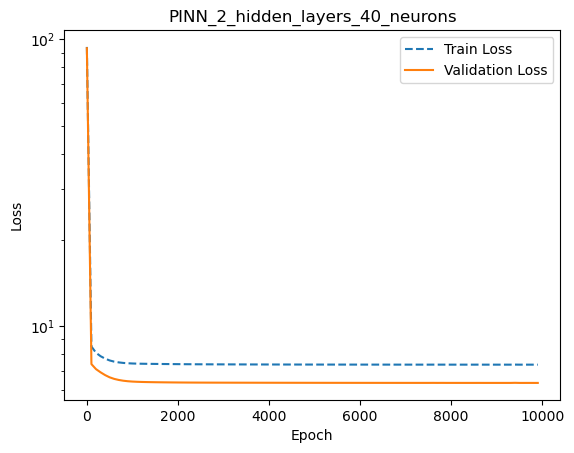

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

0 	Loss(training) = 0.9893823333514938 	Loss(validation) = 0.8796130605403386
100 	Loss(training) = 0.5977163966213638 	Loss(validation) = 0.6156659930347886
200 	Loss(training) = 0.3006313298026949 	Loss(validation) = 0.3938037034263979
300 	Loss(training) = 0.15461736384809274 	Loss(validation) = 0.2594332372999852
400 	Loss(training) = 0.08112954158425197 	Loss(validation) = 0.1836416518974129
500 	Loss(training) = 0.043154056170649574 	Loss(validation) = 0.13745608427793318
600 	Loss(training) = 0.02467309052723422 	Loss(validation) = 0.11516850057752118
700 	Loss(training) = 0.015642876513064827 	Loss(validation) = 0.10248870390422975
800 	Loss(training) = 0.010686202215679218 	Loss(validation) = 0.09269679609969632
900 	Loss(training) = 0.007671475446239271 	Loss(validation) = 0.08473573587242246
1000 	Loss(training) = 0.005721138122739717 	Loss(validation) = 0.07845918137439346
1100 	Loss(training) = 0.004408280574575747 	Loss(validation) = 0.07373039680711793
1200 	Loss(trainin

9700 	Loss(training) = 3.647868166479076e-05 	Loss(validation) = 0.029140542119078884
9800 	Loss(training) = 2.568307580600639e-05 	Loss(validation) = 0.02900241839075708
9900 	Loss(training) = 2.5236983418395593e-05 	Loss(validation) = 0.028896333999325965


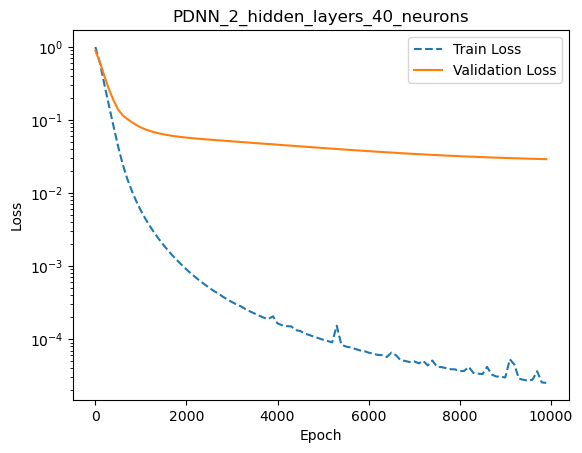

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=40000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 	Loss(training) = 76.21301879011564 	Loss(validation) = 68.43907493358505
100 	Loss(training) = 9.306722661109593 	Loss(validation) = 9.353577913988111
200 	Loss(training) = 9.097918349315417 	Loss(validation) = 9.145893489892856
300 	Loss(training) = 8.971545633923496 	Loss(validation) = 9.030037277152145
400 	Loss(training) = 8.877290532096506 	Loss(validation) = 8.937909428454278
500 	Loss(training) = 8.798382461826622 	Loss(validation) = 8.859499389780165
600 	Loss(training) = 8.72529746945981 	Loss(validation) = 8.789796445689001
700 	Loss(training) = 8.653770124617697 	Loss(validation) = 8.726618293734003
800 	Loss(training) = 8.584746336786534 	Loss(validation) = 8.669488358229067
900 	Loss(training) = 8.520456259126394 	Loss(validation) = 8.617178581219035
1000 	Loss(training) = 8.46293284065888 	Loss(validation) = 8.570027704993274
1100 	Loss(trai

10300 	Loss(training) = 7.479421653405722 	Loss(validation) = 19.62420259224846
10400 	Loss(training) = 7.471899500357575 	Loss(validation) = 20.068805756361137
10500 	Loss(training) = 7.464650948022301 	Loss(validation) = 20.52879586742398
10600 	Loss(training) = 7.457827765033831 	Loss(validation) = 21.01650483384924
10700 	Loss(training) = 7.451311303387622 	Loss(validation) = 21.516277238326126
10800 	Loss(training) = 7.445738361208217 	Loss(validation) = 22.017401409118644
10900 	Loss(training) = 7.439105613905992 	Loss(validation) = 22.560041052297272
11000 	Loss(training) = 7.43337698111245 	Loss(validation) = 23.100590482473056
11100 	Loss(training) = 7.427895499661461 	Loss(validation) = 23.652837607032993
11200 	Loss(training) = 7.422631955460332 	Loss(validation) = 24.207512353143635
11300 	Loss(training) = 7.417766419548233 	Loss(validation) = 24.74872134142911
11400 	Loss(training) = 7.413837729835653 	Loss(validation) = 25.307239731076038
11500 	Loss(training) = 7.4084366

20600 	Loss(training) = 7.217440661826371 	Loss(validation) = 68.20640599095535
20700 	Loss(training) = 7.2213033848799 	Loss(validation) = 68.58731186766197
20800 	Loss(training) = 7.215226454338704 	Loss(validation) = 68.7359234400129
20900 	Loss(training) = 7.214109335580816 	Loss(validation) = 69.01313220010371
21000 	Loss(training) = 7.213059858124649 	Loss(validation) = 69.26667961246713
21100 	Loss(training) = 7.211977973090698 	Loss(validation) = 69.54484486999635
21200 	Loss(training) = 7.210900687869653 	Loss(validation) = 69.81790730177784
21300 	Loss(training) = 7.209928019433315 	Loss(validation) = 70.06134703108597
21400 	Loss(training) = 7.208874852205065 	Loss(validation) = 70.33444971905888
21500 	Loss(training) = 7.208539066788415 	Loss(validation) = 70.61598201967583
21600 	Loss(training) = 7.206869489951581 	Loss(validation) = 70.86071585411278
21700 	Loss(training) = 7.205884536230717 	Loss(validation) = 71.12916578050958
21800 	Loss(training) = 7.2049521471817135 

30900 	Loss(training) = 7.153443058880579 	Loss(validation) = 92.68588619450394
31000 	Loss(training) = 7.154294733202481 	Loss(validation) = 92.77503378097248
31100 	Loss(training) = 7.157095767270329 	Loss(validation) = 92.90388412391127
31200 	Loss(training) = 7.151673340883665 	Loss(validation) = 93.09369355461604
31300 	Loss(training) = 7.15137629621778 	Loss(validation) = 93.25004788650223
31400 	Loss(training) = 7.157201048295969 	Loss(validation) = 93.53479402970513
31500 	Loss(training) = 7.150681326999779 	Loss(validation) = 93.5830258905088
31600 	Loss(training) = 7.159974633405619 	Loss(validation) = 93.70615694266448
31700 	Loss(training) = 7.150044606926316 	Loss(validation) = 93.89591621993748
31800 	Loss(training) = 7.149720311225198 	Loss(validation) = 94.06298406865065
31900 	Loss(training) = 7.149457879141401 	Loss(validation) = 94.2478843452821
32000 	Loss(training) = 7.150410170324938 	Loss(validation) = 94.37254639323098
32100 	Loss(training) = 7.148780866159013 	

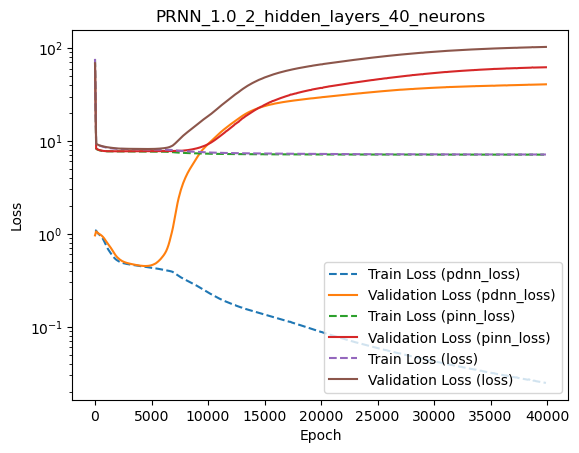

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
np.random.seed(0)

reduction_method.initialize_testing_set(100)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0,:])

#### 4.6.2 PINN Error Analysis

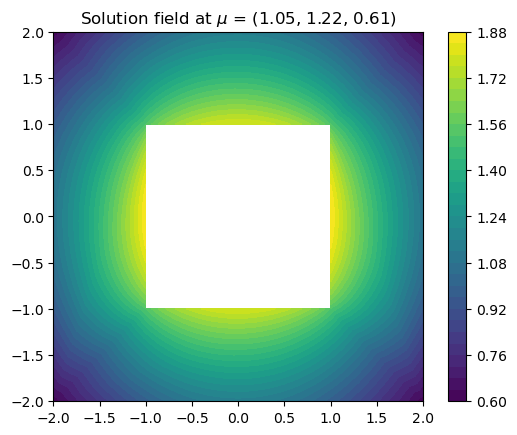

In [18]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

In [19]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn
)

################################# PINN N = 12 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.7007834805048345	0.7007280354413636	0.00013456642439096784
mean	0.9305997837969251	0.9306030908822808	0.0017663440358356493
max	1.0605816637241516	1.060574838476932	0.0070671932464277856


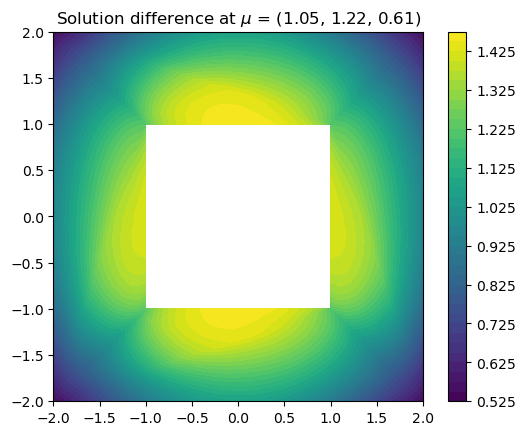

In [20]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [21]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn
)

################################# PDNN N = 12 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.00046988440267070635	0.0004076338964468774	0.00013456642439096784
mean	0.014455688701181014	0.014040775893124942	0.0017663440358356493
max	0.19323395749083014	0.19322935713712594	0.0070671932464277856


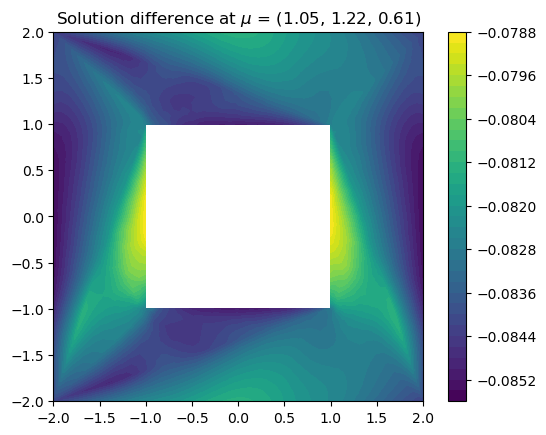

In [22]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn
)

############################### PRNN_1.0 N = 12 ################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.018307192654268212	0.018300897934753514	0.00013456642439096784
mean	0.407920184792602	0.4078886972351664	0.0017663440358356493
max	4.156428213355008	4.156132242640494	0.0070671932464277856


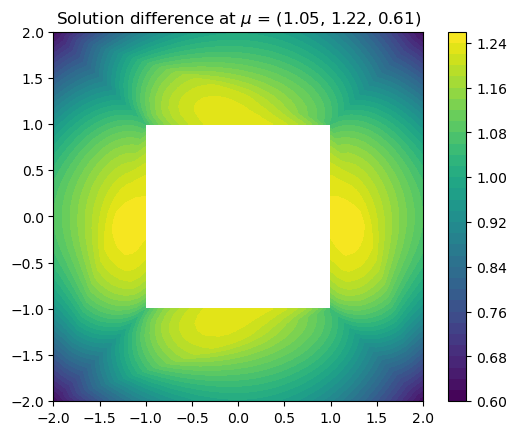

In [24]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [25]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for N = 12 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.9305997837969251	0.9306030908822808	0.0017663440358356493
pdnn_net	0.014455688701181014	0.014040775893124942	0.0017663440358356493
prnn_net	0.407920184792602	0.4078886972351664	0.0017663440358356493
#####################################################################################


### 4.7. Perform a speedup analysis

In [26]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()
reduction_method.speedup_analysis()

=                   Hole POD-Galerkin error analysis begins                    =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 99 ######################################

N 	gmean(error_u)      	max(error_u)       	gmean(relative_error_u)	max(relative_error_u)
1 	2.2784285995779565  	38.951389769181056 	0.3433598637090047     	0.7198194019894668   
2 	0.6407971717218132  	2.736730143562617  	0.09656832326818292    	0.2528619642957928   
3 	0.3728878461127491  	1.8734286424887716 	0.0561943086756084     	0.21566662499664857  
4 	0.12900590612218632 	0.5840061005757856 	0.019441228200864226   	0.07403820982528887  
5 	0.10221623832312471 	0.5624842444840263 	0.015404017341590776   	0.046542273752711215 
6 	0.07394471910133242 	0.4001510241423702 	0.011143491034714521   	0.04089347782647372  
7 	0.05011912284810023 	0.2091292927854314 	0.007552966633901192   	0.03416397269637856  
8 	0.032656590035050156	0.1538540946646988 	0.004921357775140594   	0.02532526254944985  
9 	0.02460781566983896 	0.10427198867101799	0.0037084050982055436  	0.02520094998320444  
10	0.0186200844789

###################################### 80 ######################################
###################################### 81 ######################################
###################################### 82 ######################################
###################################### 83 ######################################
###################################### 84 ######################################
###################################### 85 ######################################
###################################### 86 ######################################
###################################### 87 ######################################
###################################### 88 ######################################
###################################### 89 ######################################
###################################### 90 ######################################
###################################### 91 ######################################
############################